### This is the pytorch blitz classification exercise.

In [3]:
import torch


# torchvision is a nice wrapper for a bunch of standard training and test sets.
import torchvision
import torchvision.transforms as transforms

In [4]:

# transforms.Compose has an odd syntax. If it were composing functions, 
# I'd think it would take function names without calling them,
# but it calls them. See this example.

print(transforms.Compose.__doc__)

Composes several transforms together.

    Args:
        transforms (List[Transform]): list of transforms to compose.

    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    


In [5]:
## As best I can tell from reading the docs -- which are not definitive on this point --
# statements like 'transforms.CenterCrop(10)' produce a class member. 
type(transforms.CenterCrop(10))

torchvision.transforms.CenterCrop

In [6]:
#transforms.Normalize: the first argument is the estimated mean of the (R,G,B) channels, 
# and the second is the estimated 
# standard deviation.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


horse  ship   car   car


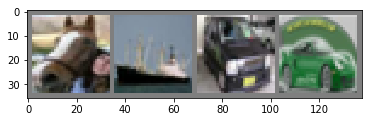

In [7]:
# Looking at the training images 
# they are small. Dog looks like a cat to me.

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Copy the neural net over from the previous section. Modify it to take 3-channel input images.

The following code creates a neural net with the following layers:
Input: 3x32x32
C1: 6@28x28 -- by applying 6 5x5 convolutions (the only change is that the 3 channels are all folded into the 6 output channels)
S2: 6@14x14 -- by subsampling (maxpooling?) each of the 6 channels
C3: 16@ 10x10 -- by applying 16 5x5 convolutions (? 16?)
S4: 16@ 5x5 -- subsampling each of the 16 channels
F5: fully connected layer, 120
F6: fully connected layer, 84
F7: fully connected layer, 10 (outputs)

Note also that max_pool2d(F.relu(self.conv1(x)), (2, 2)) are replaced with an apparently equivalent function held in a class variable. 

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### Now define the loss function and optimization method.

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Next up: understand what the code that follows is doing. 

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    ### running loss is reset to zero at the beginning of every epoch.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        # inputs is actually a 4D tensor of size (4, 3, 32, 32)
        # (to see this, call inputs.size())
        # representing a batch of 4 images, with 4 labels -- these are actually the indices of the relevant classes. 
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        # note -- optimizer has a 'grip' on the neural net parameters. It can call zero_grad, 
        # and add the contents of the grad tensors to the parameters it holds (in the step function). 
        optimizer.zero_grad()

        # forward + backward + optimize
        # call forward on the input batch
        outputs = net(inputs)
        # calculate the loss function , in this case it will be cross entropy
        loss = criterion(outputs, labels)
        
        # back propagate and add the gradient
        loss.backward()
        optimizer.step()

        # print statistics out at every 2000 mini-batches
        running_loss += loss.data[0]
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %4.3f' % (epoch+1, i+1, running_loss / 2000))

            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.231
[1,  4000] loss: 1.875
[1,  6000] loss: 1.669
[1,  8000] loss: 1.589
[1, 10000] loss: 1.524
[1, 12000] loss: 1.463
[2,  2000] loss: 1.371
[2,  4000] loss: 1.353
[2,  6000] loss: 1.341
[2,  8000] loss: 1.312
[2, 10000] loss: 1.291
[2, 12000] loss: 1.294
Finished Training


GroundTruth:    cat  ship  ship plane


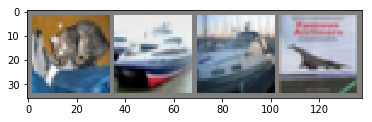

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# look at the first batch of test images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
# run these images through the net. Recall that the test images were already normalized too.
outputs = net(Variable(images))

# outputs are Variables. Get the tensors out.
print(type(outputs.data))

#look at the tensors. There is a result for each of the 3D images in the batch of 4, 
# so outputs.data is a 4x10 tensor.
# what you want to do is to apply the max function across the 2nd dimension -- calling 'torch.max' will just apply it across all dimensions.
print(torch.max(outputs.data))

<class 'torch.FloatTensor'>
5.1839189529418945


In [13]:
# calling torch.max with a second argument of 1 will apply it across the 2nd dimension, which has index 1.
# the return value consists of a list (I think it's a list) of 2 4x1 tensors.
# the first 4x1 tensor is a float tensor containing the maxes in each dimension. 
# the second 4x1 tensor is a long int tensor containing the indices of the maxes in each dimension. 
print(torch.max(outputs.data, 1)) 

(
 2.8480
 5.1839
 2.5595
 4.0118
[torch.FloatTensor of size 4x1]
, 
 3
 1
 8
 0
[torch.LongTensor of size 4x1]
)


In [14]:
# that second tensor, the LongTensor of indices, is the only one we want to use.
# So now they use an odd idiom which turns out to be standard practice in Python:
# if you have a return value from a function call that you're not going to use, you 
# name it 'underscore'. See http://stackoverflow.com/questions/5893163/what-is-the-purpose-of-the-single-underscore-variable-in-python

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [15]:
# Now check the accuracy on the entire test set. Keep in mind there are 10 classes,
# so random guessing would give a 10% probability of success.
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [16]:

# Now do a class by class breakdown on the accuracy. Better would be a confusion matrix...

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 75 %
Accuracy of  bird : 25 %
Accuracy of   cat : 47 %
Accuracy of  deer : 32 %
Accuracy of   dog : 58 %
Accuracy of  frog : 69 %
Accuracy of horse : 65 %
Accuracy of  ship : 52 %
Accuracy of truck : 58 %


In [17]:
# Now do a class by class breakdown on the accuracy. Better would be a confusion matrix...
import numpy as np
confusion = np.zeros((10,10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    
    # remember that predicted == torch.max(outputs.data, 1)[1] will be a 4x1 long integer tensor. 
    _, predicted = torch.max(outputs.data, 1) 
    

    # confusion(predicted, labels)
    # the columns will sum up to the actual total number of items labeled with a class
    # so normalize by the column sum.
    for ii in range(len(labels)):
        confusion[predicted[ii][0]][labels[ii]] +=1
        


In [18]:
# confusion matrix has true labels on the columns, assigned labels on the rows. 
# the true classes are balanced -- 1000 examples per class.
class_totals = np.apply_along_axis(np.sum, 0, confusion)
# print(class_totals)

normed_confusion = confusion.copy()

# how do I get the normalization to happen properly without looping? broadcasting?
# if I do this, then I think the division gets applied columnwise, which would be right.
# yes, it is. I got lucky.
normed_confusion/=class_totals
print(normed_confusion)

[[ 0.629  0.02   0.064  0.014  0.028  0.007  0.006  0.009  0.188  0.035]
 [ 0.052  0.752  0.015  0.012  0.015  0.005  0.016  0.01   0.076  0.194]
 [ 0.044  0.007  0.256  0.024  0.059  0.018  0.02   0.008  0.018  0.003]
 [ 0.068  0.036  0.201  0.476  0.14   0.234  0.143  0.086  0.054  0.054]
 [ 0.017  0.001  0.085  0.025  0.323  0.02   0.023  0.034  0.006  0.001]
 [ 0.032  0.018  0.177  0.289  0.115  0.587  0.064  0.145  0.035  0.026]
 [ 0.02   0.016  0.127  0.09   0.174  0.053  0.69   0.021  0.011  0.027]
 [ 0.016  0.017  0.052  0.043  0.127  0.064  0.02   0.659  0.011  0.052]
 [ 0.06   0.025  0.012  0.005  0.013  0.005  0.003  0.002  0.522  0.022]
 [ 0.062  0.108  0.011  0.022  0.006  0.007  0.015  0.026  0.079  0.586]]


In [19]:
# format the output of the confusion matrix. That extra greater-than symbol 
# causes the titles to be right justified, which matches the numerical output.
format_term = "{:>10}" * 11

# note use of the * operator for unpacking the second (list) arguments in the format call.
# 
print(format_term.format("   ", *classes))
for ii in range(10):
    print(format_term.format(classes[ii], *confusion[ii][:])) 


               plane       car      bird       cat      deer       dog      frog     horse      ship     truck
     plane     629.0      20.0      64.0      14.0      28.0       7.0       6.0       9.0     188.0      35.0
       car      52.0     752.0      15.0      12.0      15.0       5.0      16.0      10.0      76.0     194.0
      bird      44.0       7.0     256.0      24.0      59.0      18.0      20.0       8.0      18.0       3.0
       cat      68.0      36.0     201.0     476.0     140.0     234.0     143.0      86.0      54.0      54.0
      deer      17.0       1.0      85.0      25.0     323.0      20.0      23.0      34.0       6.0       1.0
       dog      32.0      18.0     177.0     289.0     115.0     587.0      64.0     145.0      35.0      26.0
      frog      20.0      16.0     127.0      90.0     174.0      53.0     690.0      21.0      11.0      27.0
     horse      16.0      17.0      52.0      43.0     127.0      64.0      20.0     659.0      11.0      52.0
 

### Observations on the training so far

    frequently cats are mistaken for dogs and horses. 
    but horses are infrequently mistaken for other animals.
    Planes are frequently mistaken for ships and vice versa.
    Deer and birds are mistaken for cats, deer, and planes. And horses. 

Finally, training for 10 epochs doesn't improve the outcome much over training for 2 epochs. 

In [20]:
# FINALLY, FOR THE LAST EXERCISE YOU NEED CUDA. NEXT STEP IS TO GET IT INSTALLED.
# The goal is for this function to return True.
torch.cuda.is_available()

False